# General information

...

## M/M/n queues for FIFO

In [2]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
def interval_generator(num_servers, load_factor, service_rate):
    return random.expovariate(num_servers * load_factor * service_rate)

def service_time_generator(service_rate):
    return random.expovariate(service_rate)

def client_process(env, resources, service_rate, wait_records):
    arrival_time = env.now
    with resources.request() as request:
        yield request
        wait_time = env.now - arrival_time
        wait_records.append(wait_time)  
        yield env.timeout(service_time_generator(service_rate))  

def request_spawner(env, resources, num_servers, load_factor, service_rate, wait_records):
    while True:
        yield env.timeout(interval_generator(num_servers, load_factor, service_rate))
        env.process(client_process(env, resources, service_rate, wait_records))

def run_simulation(num_servers, load_factor, service_rate, sim_time):
    env = simpy.Environment()
    resources = simpy.Resource(env, capacity=num_servers)
    wait_records = []  
    env.process(request_spawner(env, resources, num_servers, load_factor, service_rate, wait_records))
    env.run(until=sim_time)
    return wait_records

Running simulations for different load factors:   0%|          | 0/4 [00:00<?, ?it/s]

Running simulations for different load factors: 100%|██████████| 4/4 [00:24<00:00,  6.21s/it]


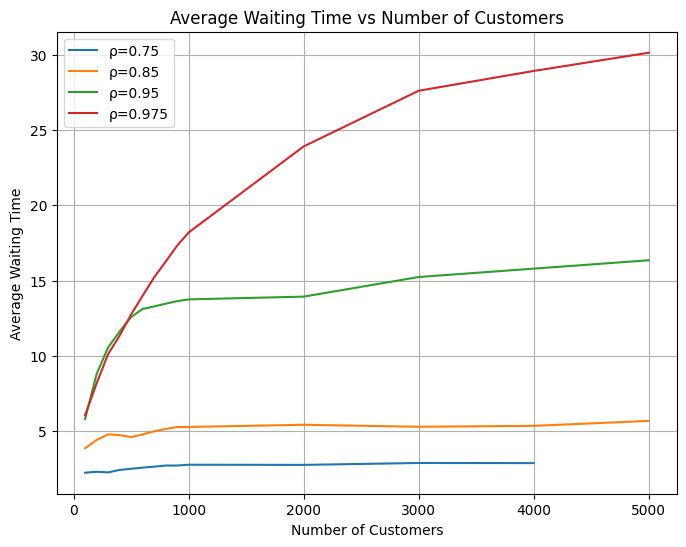

In [6]:
load_factors = [0.75, 0.85, 0.95, 0.975]
servers_count = 1
service_rate = 1.0
simulation_time = 6000
runs_per_config = 50 

results_data = []

for load in tqdm(load_factors, desc="Running simulations for different load factors"):
    # We need to fix this to make it appear normally...
    for iteration in tqdm(range(runs_per_config), leave=False, desc=f"Simulating for ρ={load:.2f}"):
        recorded_waits = run_simulation(servers_count, load, service_rate, simulation_time)
        customer_counts = np.concatenate(
            (np.arange(100, 1000, 100), np.arange(1000, 10000, 1000), np.arange(10000, 100001, 10000))
        )
        for count in customer_counts:
            if count <= len(recorded_waits):
                average_wait = np.mean(recorded_waits[:count])
                results_data.append([iteration, load, servers_count, count, average_wait])

results_df = pd.DataFrame(
    results_data, columns=["Iteration", "Load Factor", "Servers", "Customers", "Mean Wait Time"]
)

results_df.to_csv("simulations_output.csv", index=False)

plt.figure(figsize=(8, 6))
for load in load_factors:
    subset = results_df[results_df["Load Factor"] == load]
    avg_waits = subset.groupby("Customers")["Mean Wait Time"].mean()
    plt.plot(avg_waits.index, avg_waits.values, label=f"ρ={load}")

plt.title("Average Waiting Time vs Number of Customers")
plt.xlabel("Number of Customers")
plt.ylabel("Average Waiting Time")
plt.legend()
plt.grid(True)
plt.show()

Running simulations for different load factors: 100%|██████████| 4/4 [00:24<00:00,  6.04s/it]


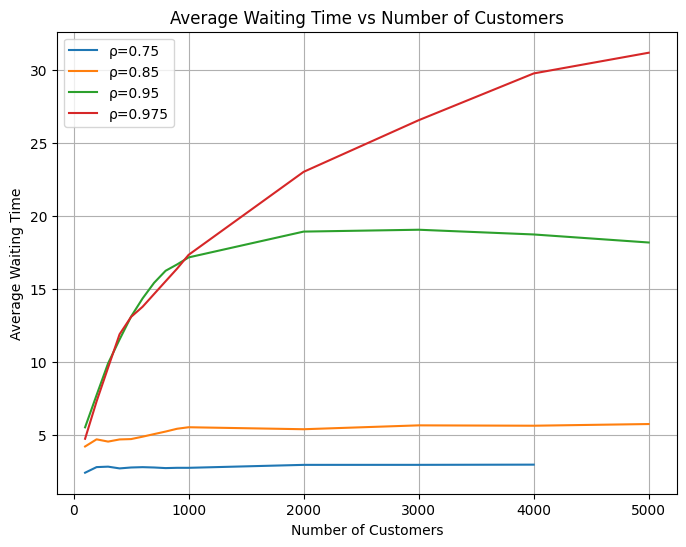

In [7]:
# Parameters
load_factors = [0.75, 0.85, 0.95, 0.975]
servers_count = 1
service_rate = 1.0
simulation_time = 6000
runs_per_config = 50 

# Using a dictionary for results storage
results_dict = {
    "Load Factor": [],
    "Servers": [],
    "Customers": [],
    "Iteration": [],
    "Mean Wait Time": []
}

# Simulations with progress bars
for load in tqdm(load_factors, desc="Running simulations for different load factors"):
    for iteration in tqdm(range(runs_per_config), leave=False, desc=f"Simulating for ρ={load:.2f}"):
        recorded_waits = run_simulation(servers_count, load, service_rate, simulation_time)
        customer_counts = np.concatenate(
            (np.arange(100, 1000, 100), np.arange(1000, 10000, 1000), np.arange(10000, 100001, 10000))
        )
        for count in customer_counts:
            if count <= len(recorded_waits):
                average_wait = np.mean(recorded_waits[:count])
                results_dict["Load Factor"].append(load)
                results_dict["Servers"].append(servers_count)
                results_dict["Customers"].append(count)
                results_dict["Iteration"].append(iteration)
                results_dict["Mean Wait Time"].append(average_wait)

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(results_dict)

# Save the results to a CSV
results_df.to_csv("simulations_output2.csv", index=False)

# Plotting the results
plt.figure(figsize=(8, 6))
for load in load_factors:
    subset = results_df[results_df["Load Factor"] == load]
    avg_waits = subset.groupby("Customers")["Mean Wait Time"].mean()
    plt.plot(avg_waits.index, avg_waits.values, label=f"ρ={load}")

plt.title("Average Waiting Time vs Number of Customers")
plt.xlabel("Number of Customers")
plt.ylabel("Average Waiting Time")
plt.legend()
plt.grid(True)
plt.show()